In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 5
commitnumber = d62b618
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [8, 8]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 257
vmax = 1100
vmin = 980
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

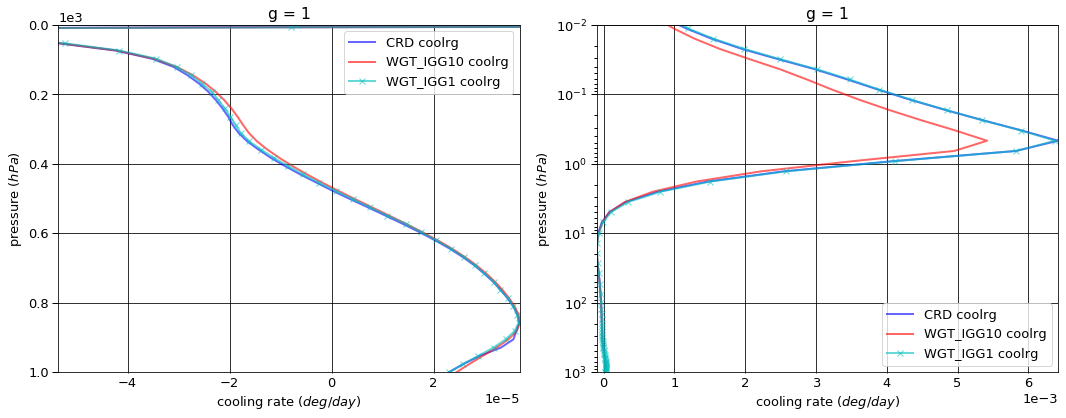

# Figure: cooling rate g-group 2

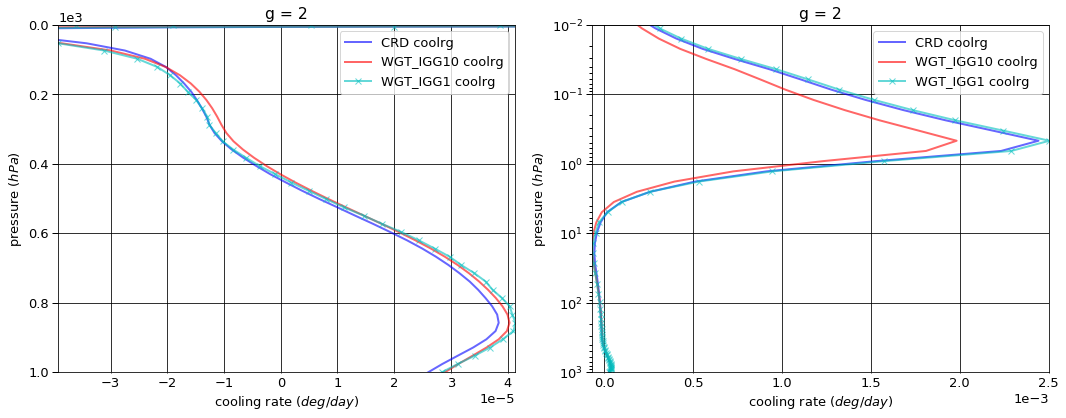

# Figure: cooling rate g-group 3

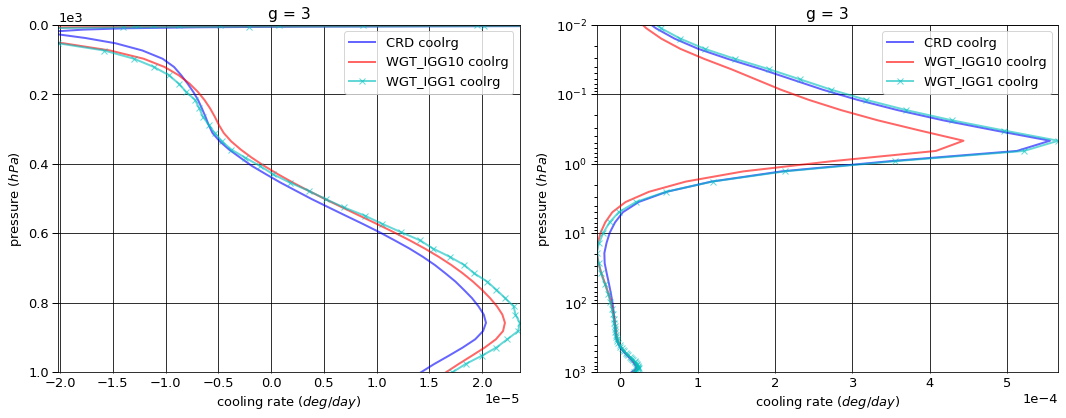

# Figure: cooling rate g-group 4

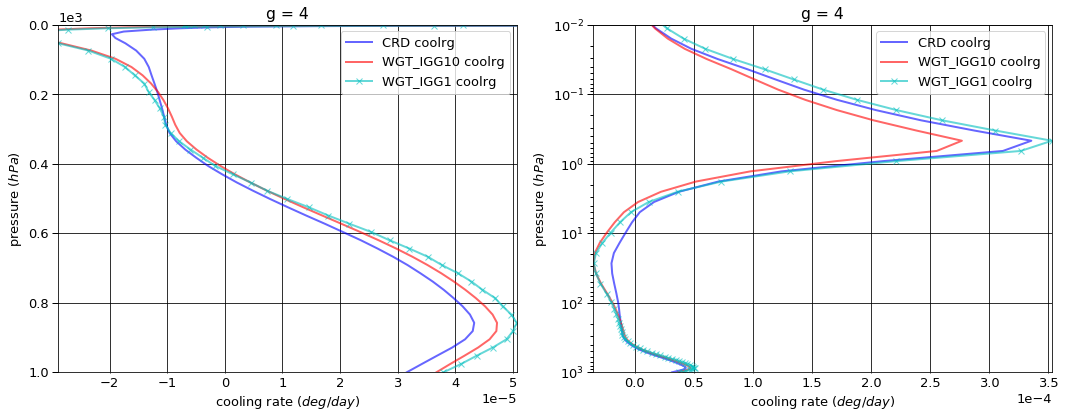

# Figure: cooling rate g-group 5

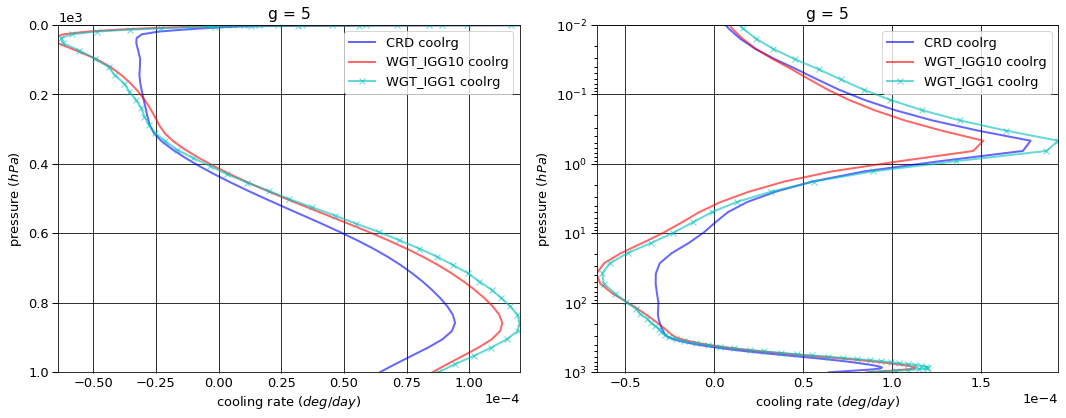

# Figure: cooling rate g-group 6

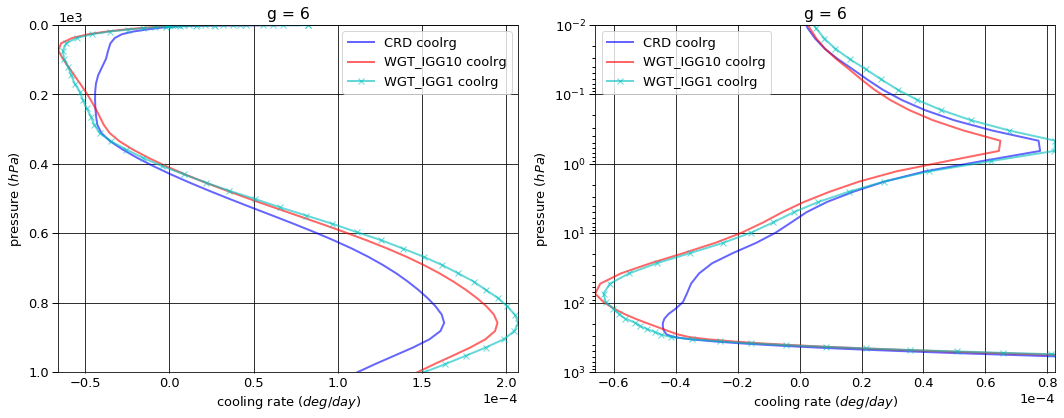

# Figure: cooling rate g-group 7

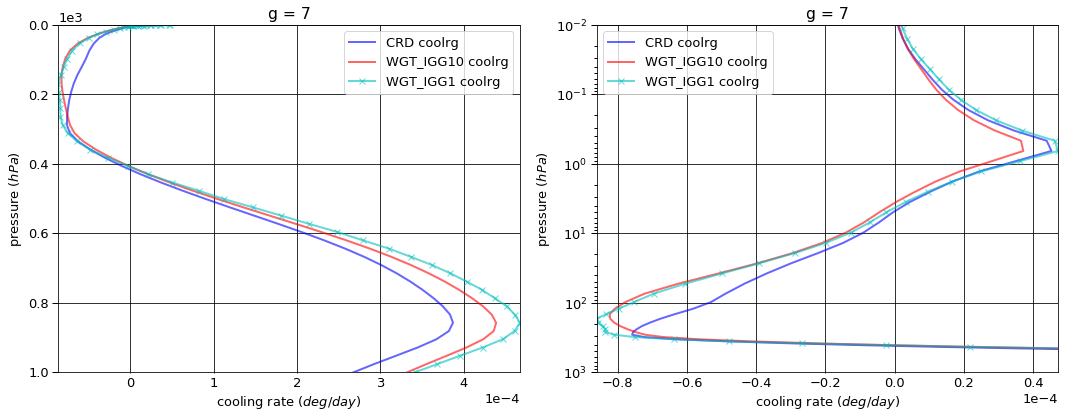

# Figure: cooling rate g-group 8

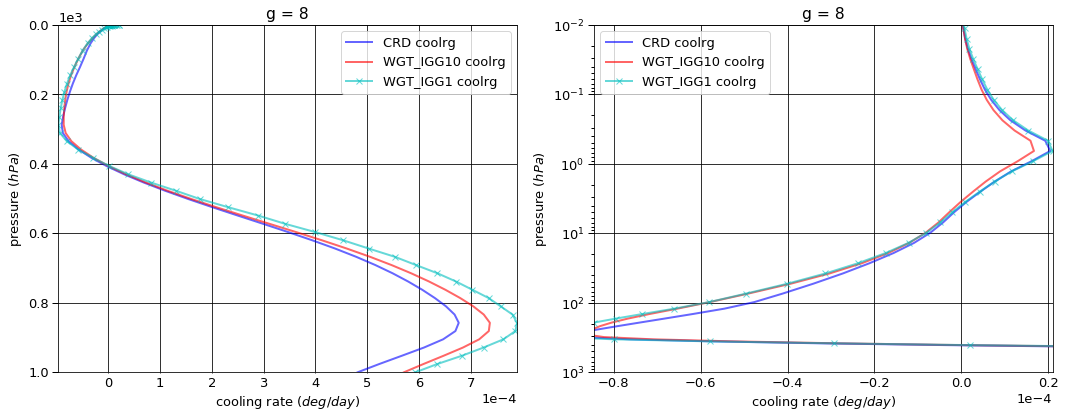

# Figure: cooling rate g-group 9

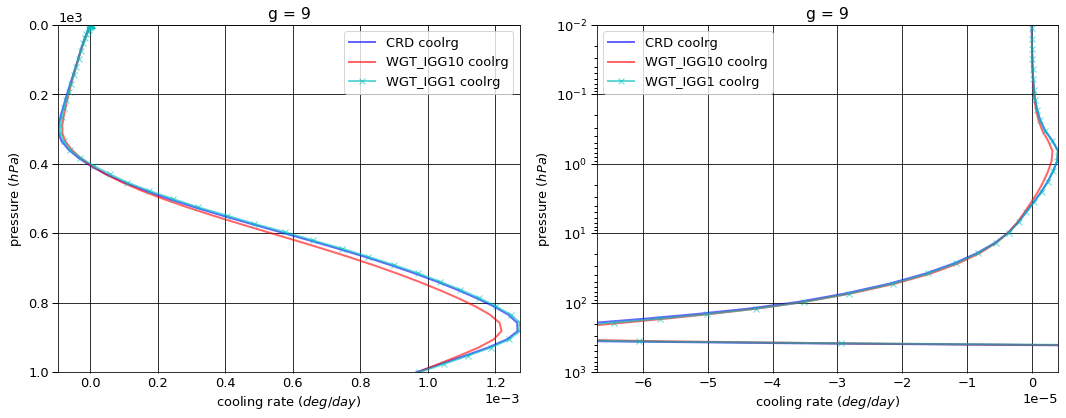

# Figure: cooling rate g-group 10

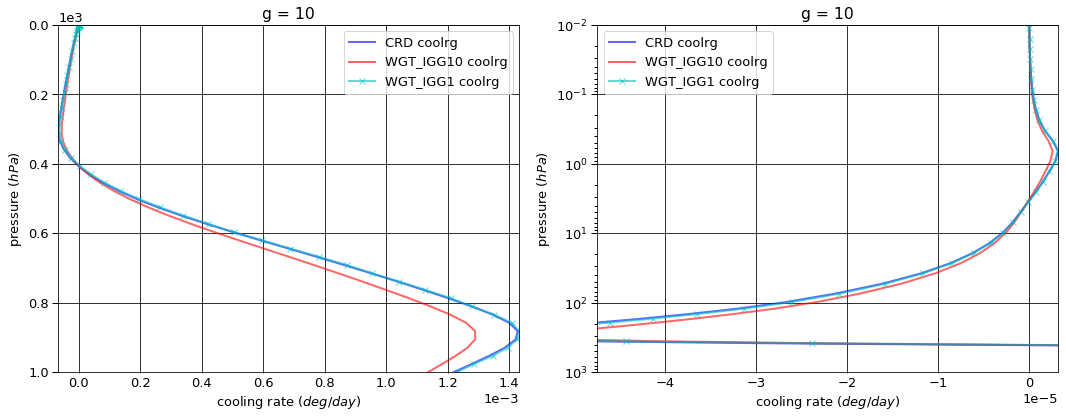

# Figure: cooling rate g-group 11

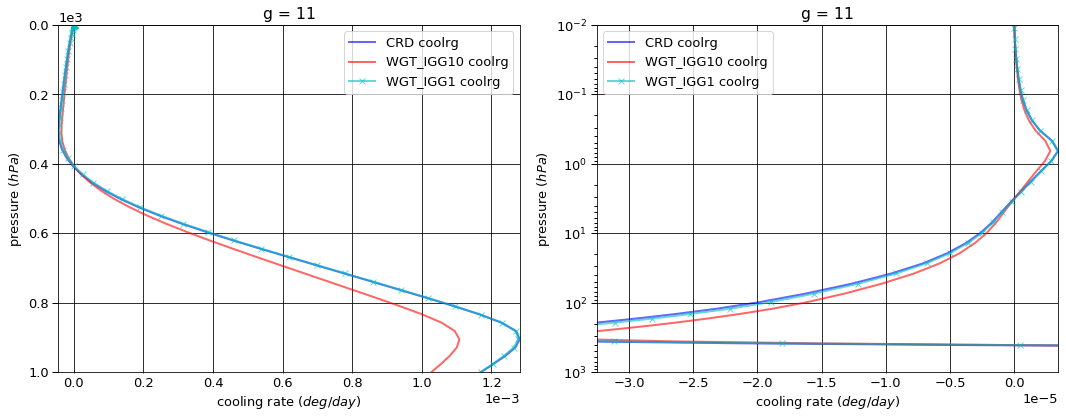

# Figure: cooling rate g-group 12

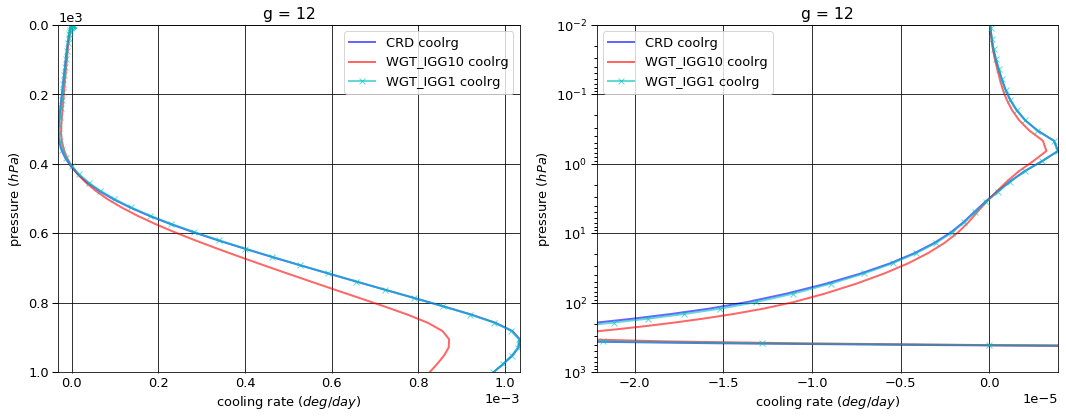

# Figure: cooling rate g-group 13

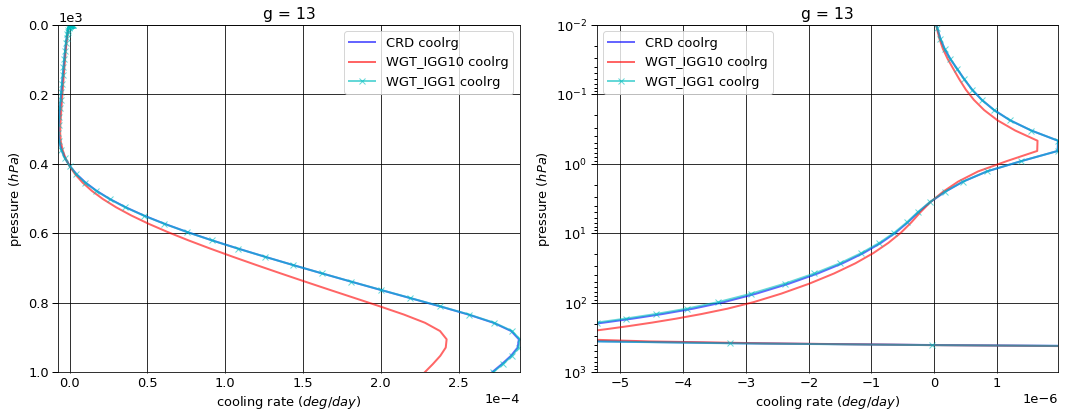

# Figure: cooling rate g-group 14

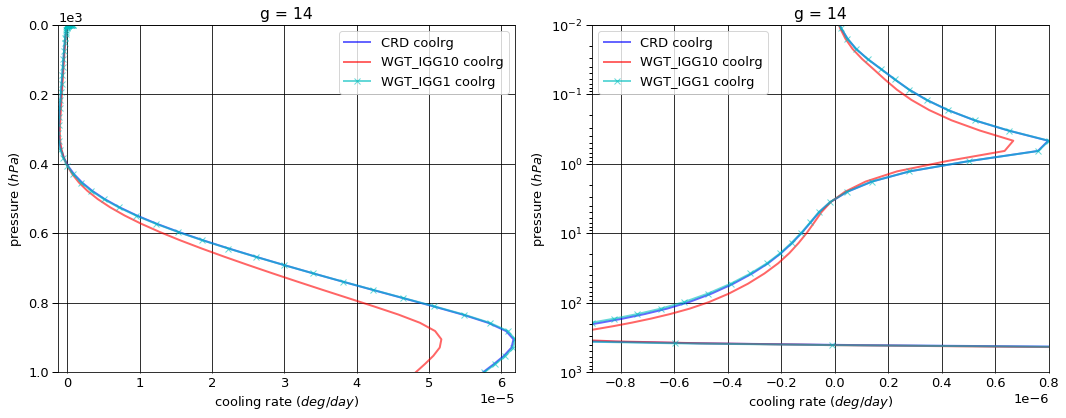

# Figure: cooling rate g-group 15

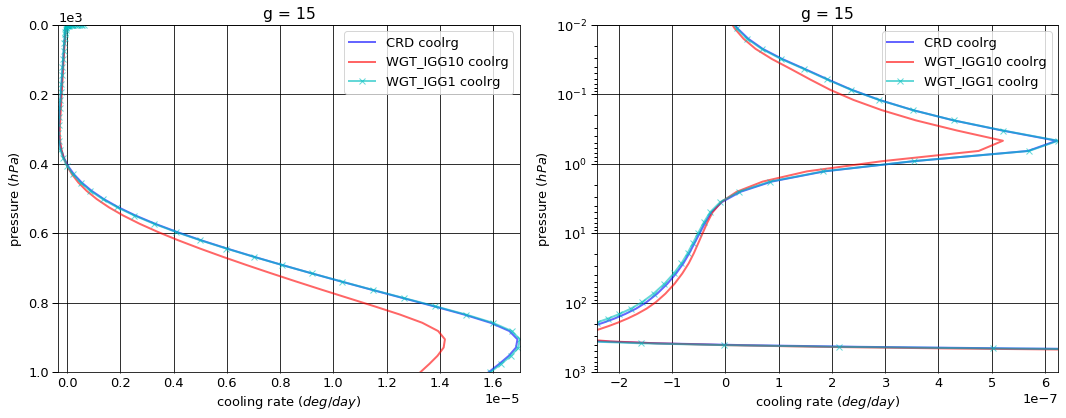

# Figure: cooling rate g-group 16

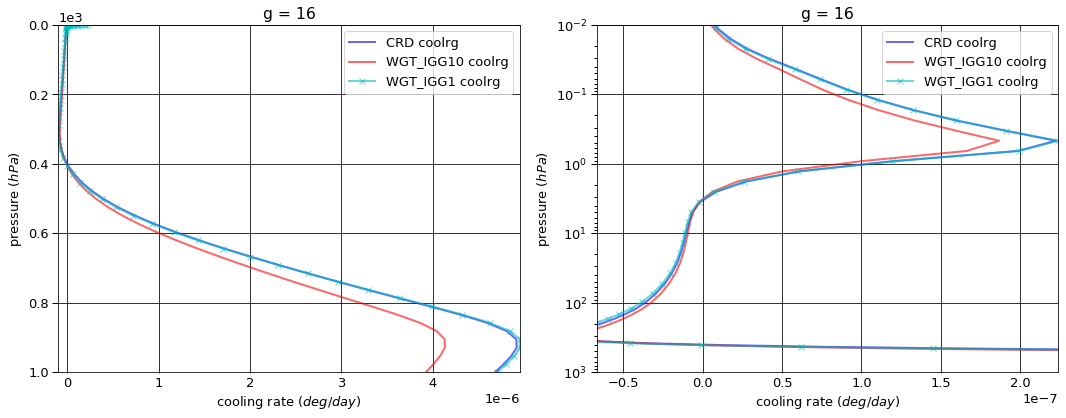

# Figure: cooling rate g-group total

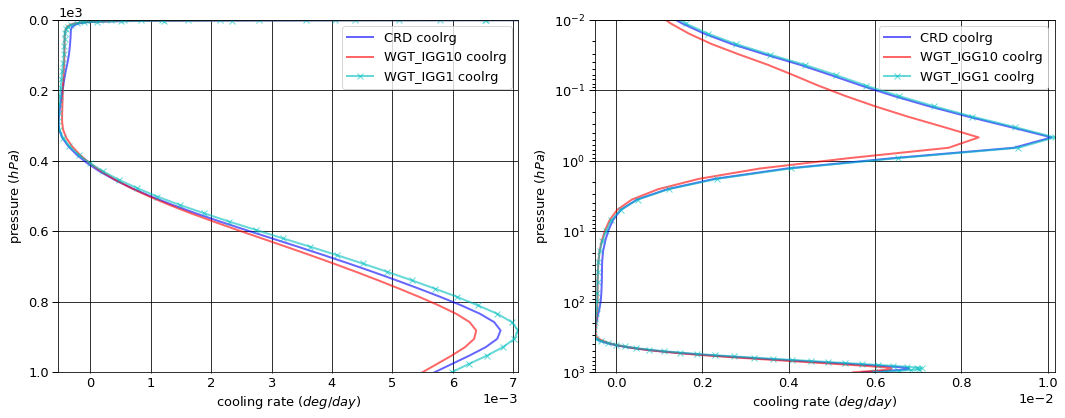

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.005046  0.000000 -0.005046
   1013.0   76    -0.007561  0.003673 -0.003888
2  0.0      1     -0.010373  0.000000 -0.010373
   1013.0   76    -0.012571  0.003399 -0.009172
3  0.0      1     -0.009685  0.000000 -0.009685
   1013.0   76    -0.010748  0.001674 -0.009074
4  0.0      1     -0.020114  0.000000 -0.020114
   1013.0   76    -0.021774  0.003107 -0.018667
5  0.0      1     -0.045253  0.000000 -0.045253
   1013.0   76    -0.049360  0.007167 -0.042193
6  0.0      1     -0.077229  0.000000 -0.077229
   1013.0   76    -0.083366  0.011964 -0.071402
7  0.0      1     -0.161551  0.000000 -0.161551
   1013.0   76    -0.172546  0.026369 -0.146177
8  0.0      1     -0.286061  0.000000 -0.286061
   1013.0   76    -0.299651  0.042179 -0.257472
9  0.0      1     -0.306993  0.000000 -0.306993
   1013.0   76    -0.322550  0.069406 -0.253145
10 0.0      1     -0.724800  0.000000 -0.724800
   1013.0   76    -0.736127  0.069267 -0.666859
11 0.0      1     -1.703805  0.000000 -1.703805
   1013.0   76    -1.711606  0.057806 -1.653801
12 0.0      1     -3.637960  0.000000 -3.637960
   1013.0   76    -3.643397  0.044904 -3.598493
13 0.0      1     -2.938148  0.000000 -2.938148
   1013.0   76    -2.939511  0.012328 -2.927183
14 0.0      1     -1.967926  0.000000 -1.967926
   1013.0   76    -1.968178  0.002577 -1.965601
15 0.0      1     -1.656669  0.000000 -1.656669
   1013.0   76    -1.656736  0.000701 -1.656035
16 0.0      1     -1.415707  0.000000 -1.415707
   1013.0   76    -1.415726  0.000203 -1.415523


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.004920  0.000000 -0.004920
   1013.0   76    -0.007527  0.003745 -0.003782
2  0.0      1     -0.010327  0.000000 -0.010327
   1013.0   76    -0.012573  0.003485 -0.009088
3  0.0      1     -0.009590  0.000000 -0.009590
   1013.0   76    -0.010718  0.001790 -0.008927
4  0.0      1     -0.019902  0.000000 -0.019902
   1013.0   76    -0.021693  0.003371 -0.018322
5  0.0      1     -0.044767  0.000000 -0.044767
   1013.0   76    -0.049241  0.008269 -0.040972
6  0.0      1     -0.076702  0.000000 -0.076702
   1013.0   76    -0.083153  0.013612 -0.069541
7  0.0      1     -0.161245  0.000000 -0.161245
   1013.0   76    -0.172088  0.028499 -0.143588
8  0.0      1     -0.286314  0.000000 -0.286314
   1013.0   76    -0.298969  0.043857 -0.255112
9  0.0      1     -0.307853  0.000000 -0.307853
   1013.0   76    -0.321395  0.065249 -0.256146
10 0.0      1     -0.724617  0.000000 -0.724617
   1013.0   76    -0.734141  0.061758 -0.672383
11 0.0      1     -1.699871  0.000000 -1.699871
   1013.0   76    -1.706299  0.049616 -1.656682
12 0.0      1     -3.629165  0.000000 -3.629165
   1013.0   76    -3.633631  0.037800 -3.595831
13 0.0      1     -2.941162  0.000000 -2.941162
   1013.0   76    -2.942305  0.010324 -2.931981
14 0.0      1     -1.972517  0.000000 -1.972517
   1013.0   76    -1.972730  0.002154 -1.970576
15 0.0      1     -1.662440  0.000000 -1.662440
   1013.0   76    -1.662496  0.000586 -1.661910
16 0.0      1     -1.422430  0.000000 -1.422430
   1013.0   76    -1.422446  0.000169 -1.422277


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.005027  0.000000 -0.005027
   1013.0   76    -0.007527  0.003725 -0.003802
2  0.0      1     -0.010246  0.000000 -0.010246
   1013.0   76    -0.012573  0.003625 -0.008948
3  0.0      1     -0.009493  0.000000 -0.009493
   1013.0   76    -0.010718  0.001932 -0.008785
4  0.0      1     -0.019715  0.000000 -0.019715
   1013.0   76    -0.021693  0.003667 -0.018026
5  0.0      1     -0.044318  0.000000 -0.044318
   1013.0   76    -0.049241  0.008950 -0.040291
6  0.0      1     -0.075997  0.000000 -0.075997
   1013.0   76    -0.083153  0.014774 -0.068378
7  0.0      1     -0.159947  0.000000 -0.159947
   1013.0   76    -0.172088  0.030954 -0.141134
8  0.0      1     -0.284578  0.000000 -0.284578
   1013.0   76    -0.298969  0.048048 -0.250921
9  0.0      1     -0.306013  0.000000 -0.306013
   1013.0   76    -0.321395  0.070088 -0.251308
10 0.0      1     -0.722945  0.000000 -0.722945
   1013.0   76    -0.734141  0.069708 -0.664433
11 0.0      1     -1.698617  0.000000 -1.698617
   1013.0   76    -1.706299  0.057913 -1.648386
12 0.0      1     -3.628282  0.000000 -3.628282
   1013.0   76    -3.633631  0.044917 -3.588714
13 0.0      1     -2.940935  0.000000 -2.940935
   1013.0   76    -2.942305  0.012340 -2.929965
14 0.0      1     -1.972475  0.000000 -1.972475
   1013.0   76    -1.972730  0.002580 -1.970150
15 0.0      1     -1.662428  0.000000 -1.662428
   1013.0   76    -1.662496  0.000702 -1.661794
16 0.0      1     -1.422427  0.000000 -1.422427
   1013.0   76    -1.422446  0.000203 -1.422243


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000126  0.000000  0.000126
   1013.0   76     0.000034  0.000071  0.000105
2  0.0      1      0.000046  0.000000  0.000046
   1013.0   76    -0.000001  0.000086  0.000084
3  0.0      1      0.000096  0.000000  0.000096
   1013.0   76     0.000030  0.000116  0.000146
4  0.0      1      0.000212  0.000000  0.000212
   1013.0   76     0.000081  0.000264  0.000345
5  0.0      1      0.000486  0.000000  0.000486
   1013.0   76     0.000118  0.001102  0.001221
6  0.0      1      0.000527  0.000000  0.000527
   1013.0   76     0.000213  0.001648  0.001861
7  0.0      1      0.000307  0.000000  0.000307
   1013.0   76     0.000458  0.002131  0.002589
8  0.0      1     -0.000253  0.000000 -0.000253
   1013.0   76     0.000681  0.001678  0.002360
9  0.0      1     -0.000859  0.000000 -0.000859
   1013.0   76     0.001155 -0.004156 -0.003001
10 0.0      1      0.000183  0.000000  0.000183
   1013.0   76     0.001985 -0.007509 -0.005524
11 0.0      1      0.003934  0.000000  0.003934
   1013.0   76     0.005308 -0.008189 -0.002882
12 0.0      1      0.008795  0.000000  0.008795
   1013.0   76     0.009766 -0.007104  0.002662
13 0.0      1     -0.003014  0.000000 -0.003014
   1013.0   76    -0.002795 -0.002003 -0.004798
14 0.0      1     -0.004591  0.000000 -0.004591
   1013.0   76    -0.004552 -0.000422 -0.004974
15 0.0      1     -0.005770  0.000000 -0.005770
   1013.0   76    -0.005760 -0.000115 -0.005875
16 0.0      1     -0.006723  0.000000 -0.006723
   1013.0   76    -0.006721 -0.000033 -0.006754


WGT_IGG1 - CRD


flug          fldg     fnetg
g  pressure level                                  
1  0.0      1      0.000019  0.000000e+00  0.000019
   1013.0   76     0.000034  5.212130e-05  0.000086
2  0.0      1      0.000128  0.000000e+00  0.000128
   1013.0   76    -0.000001  2.257119e-04  0.000224
3  0.0      1      0.000192  0.000000e+00  0.000192
   1013.0   76     0.000030  2.583688e-04  0.000288
4  0.0      1      0.000400  0.000000e+00  0.000400
   1013.0   76     0.000081  5.598541e-04  0.000641
5  0.0      1      0.000935  0.000000e+00  0.000935
   1013.0   76     0.000118  1.782712e-03  0.001901
6  0.0      1      0.001232  0.000000e+00  0.001232
   1013.0   76     0.000213  2.810273e-03  0.003023
7  0.0      1      0.001605  0.000000e+00  0.001605
   1013.0   76     0.000458  4.585007e-03  0.005043
8  0.0      1      0.001484  0.000000e+00  0.001484
   1013.0   76     0.000681  5.869353e-03  0.006551
9  0.0      1      0.000980  0.000000e+00  0.000980
   1013.0   76     0.001155  6.818740e-04  0.001837
10 0.0      1      0.001855  0.000000e+00  0.001855
   1013.0   76     0.001985  4.408150e-04  0.002426
11 0.0      1      0.005188  0.000000e+00  0.005188
   1013.0   76     0.005308  1.074910e-04  0.005415
12 0.0      1      0.009677  0.000000e+00  0.009677
   1013.0   76     0.009766  1.366800e-05  0.009779
13 0.0      1     -0.002787  0.000000e+00 -0.002787
   1013.0   76    -0.002795  1.287500e-05 -0.002782
14 0.0      1     -0.004549  0.000000e+00 -0.004549
   1013.0   76    -0.004552  3.810600e-06 -0.004548
15 0.0      1     -0.005759  0.000000e+00 -0.005759
   1013.0   76    -0.005760  1.430330e-06 -0.005759
16 0.0      1     -0.006720  0.000000e+00 -0.006720
   1013.0   76    -0.006721  5.617000e-07 -0.006720

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.087560e-04
   1001.112500 75     2.298606e-05
2  0.000312    1     -5.830702e-05
   1001.112500 75     2.599128e-05
3  0.000312    1     -1.497353e-05
   1001.112500 75     1.420352e-05
4  0.000312    1     -9.742656e-06
   1001.112500 75     3.159388e-05
5  0.000312    1     -7.721783e-06
   1001.112500 75     6.429310e-05
6  0.000312    1     -2.549868e-06
   1001.112500 75     1.115166e-04
7  0.000312    1     -1.089938e-06
   1001.112500 75     2.678633e-04
8  0.000312    1     -3.837332e-07
   1001.112500 75     4.815725e-04
9  0.000312    1     -1.928059e-09
   1001.112500 75     9.652560e-04
10 0.000312    1     -8.230087e-09
   1001.112500 75     1.219065e-03
11 0.000312    1     -2.279748e-08
   1001.112500 75     1.168794e-03
12 0.000312    1     -5.032016e-08
   1001.112500 75     9.734399e-04
13 0.000312    1     -3.813189e-08
   1001.112500 75     2.714975e-04
14 0.000312    1     -1.986148e-08
   1001.112500 75     5.749698e-05
15 0.000312    1     -1.712963e-08
   1001.112500 75     1.583213e-05
16 0.000312    1     -7.228907e-09
   1001.112500 75     4.682405e-06


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -7.763086e-05
   1001.112500 75     2.448912e-05
2  0.000312    1     -5.965670e-05
   1001.112500 75     2.892668e-05
3  0.000312    1     -1.404375e-05
   1001.112500 75     1.657660e-05
4  0.000312    1     -7.398616e-06
   1001.112500 75     3.674130e-05
5  0.000312    1     -5.348578e-06
   1001.112500 75     8.526987e-05
6  0.000312    1     -1.762079e-06
   1001.112500 75     1.471271e-04
7  0.000312    1     -7.680234e-07
   1001.112500 75     3.323064e-04
8  0.000312    1     -2.964625e-07
   1001.112500 75     5.709889e-04
9  0.000312    1     -1.702906e-09
   1001.112500 75     9.703597e-04
10 0.000312    1     -6.903186e-09
   1001.112500 75     1.136055e-03
11 0.000312    1     -1.826740e-08
   1001.112500 75     1.027036e-03
12 0.000312    1     -4.055153e-08
   1001.112500 75     8.261324e-04
13 0.000312    1     -3.133527e-08
   1001.112500 75     2.282519e-04
14 0.000312    1     -1.608492e-08
   1001.112500 75     4.818537e-05
15 0.000312    1     -1.494415e-08
   1001.112500 75     1.326568e-05
16 0.000312    1     -6.376328e-09
   1001.112500 75     3.927137e-06


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -8.886930e-05
   1001.112500 75     2.307569e-05
2  0.000312    1     -5.148335e-05
   1001.112500 75     2.840697e-05
3  0.000312    1     -1.297852e-05
   1001.112500 75     1.718497e-05
4  0.000312    1     -7.027101e-06
   1001.112500 75     3.797005e-05
5  0.000312    1     -4.989628e-06
   1001.112500 75     8.769758e-05
6  0.000312    1     -1.691420e-06
   1001.112500 75     1.512216e-04
7  0.000312    1     -7.623315e-07
   1001.112500 75     3.416632e-04
8  0.000312    1     -3.104437e-07
   1001.112500 75     5.932831e-04
9  0.000312    1     -1.777206e-09
   1001.112500 75     9.743150e-04
10 0.000312    1     -7.836820e-09
   1001.112500 75     1.230154e-03
11 0.000312    1     -2.156664e-08
   1001.112500 75     1.169273e-03
12 0.000312    1     -4.833281e-08
   1001.112500 75     9.737076e-04
13 0.000312    1     -3.748945e-08
   1001.112500 75     2.720941e-04
14 0.000312    1     -1.929110e-08
   1001.112500 75     5.766411e-05
15 0.000312    1     -1.789815e-08
   1001.112500 75     1.589395e-05
16 0.000312    1     -7.643188e-09
   1001.112500 75     4.706944e-06


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      3.112511e-05
   1001.112500 75     1.503063e-06
2  0.000312    1     -1.349688e-06
   1001.112500 75     2.935390e-06
3  0.000312    1      9.297790e-07
   1001.112500 75     2.373079e-06
4  0.000312    1      2.344040e-06
   1001.112500 75     5.147421e-06
5  0.000312    1      2.373205e-06
   1001.112500 75     2.097677e-05
6  0.000312    1      7.877890e-07
   1001.112500 75     3.561051e-05
7  0.000312    1      3.219141e-07
   1001.112500 75     6.444315e-05
8  0.000312    1      8.727075e-08
   1001.112500 75     8.941650e-05
9  0.000312    1      2.251529e-10
   1001.112500 75     5.103750e-06
10 0.000312    1      1.326901e-09
   1001.112500 75    -8.301030e-05
11 0.000312    1      4.530075e-09
   1001.112500 75    -1.417573e-04
12 0.000312    1      9.768632e-09
   1001.112500 75    -1.473075e-04
13 0.000312    1      6.796614e-09
   1001.112500 75    -4.324564e-05
14 0.000312    1      3.776564e-09
   1001.112500 75    -9.311616e-06
15 0.000312    1      2.185483e-09
   1001.112500 75    -2.566449e-06
16 0.000312    1      8.525788e-10
   1001.112500 75    -7.552676e-07


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.988667e-05
   1001.112500 75     8.963500e-08
2  0.000312    1      6.823666e-06
   1001.112500 75     2.415681e-06
3  0.000312    1      1.995006e-06
   1001.112500 75     2.981450e-06
4  0.000312    1      2.715555e-06
   1001.112500 75     6.376169e-06
5  0.000312    1      2.732156e-06
   1001.112500 75     2.340448e-05
6  0.000312    1      8.584478e-07
   1001.112500 75     3.970499e-05
7  0.000312    1      3.276060e-07
   1001.112500 75     7.379991e-05
8  0.000312    1      7.328951e-08
   1001.112500 75     1.117106e-04
9  0.000312    1      1.508525e-10
   1001.112500 75     9.059030e-06
10 0.000312    1      3.932670e-10
   1001.112500 75     1.108910e-05
11 0.000312    1      1.230836e-09
   1001.112500 75     4.799000e-07
12 0.000312    1      1.987349e-09
   1001.112500 75     2.677600e-07
13 0.000312    1      6.424360e-10
   1001.112500 75     5.965900e-07
14 0.000312    1      5.703870e-10
   1001.112500 75     1.671270e-07
15 0.000312    1     -7.685220e-10
   1001.112500 75     6.181400e-08
16 0.000312    1     -4.142812e-10
   1001.112500 75     2.453930e-08

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.967321,0.000000,-14.967321
1013.0,76,-15.051406,0.356722,-14.694684



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.973821,0.000000,-14.973821
1013.0,76,-15.051406,0.334287,-14.717119



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-14.963441,0.000000,-14.963441
1013.0,76,-15.051406,0.374128,-14.677278



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.499678e-03,0.000000,-0.006500
1013.0,76,-9.360000e-08,-0.022435,-0.022435



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.879866e-03,0.000000,0.003880
1013.0,76,-9.360000e-08,0.017406,0.017406


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000204
1001.112500,75,0.005696



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000167
1001.112500,75,0.005496



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000168
1001.112500,75,0.005978



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000037
1001.112500,75,-0.000200



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000035
1001.112500,75,0.000282


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000542,0.000500
2,0.000833,0.000835
3,0.000750,0.000712
4,0.001542,0.001441
5,0.003417,0.003272
6,0.005792,0.005525
7,0.012000,0.011433
8,0.020708,0.019863
9,0.022750,0.021353


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.625183e-21
2,4.593142e-22
3,1.298128e-22
4,3.668809e-23
5,1.036890e-23
6,2.930491e-24
7,8.282244e-25
8,2.340754e-25
9,1.618833e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.625183e-21,NaN,0.000542,0.000500,0.000542,0.000500,1.0
2,4.593142e-22,0.282623,0.000833,0.000835,0.001375,0.001335,1.0
3,1.298128e-22,0.282623,0.000750,0.000712,0.002125,0.002047,1.0
4,3.668809e-23,0.282623,0.001542,0.001441,0.003667,0.003489,1.0
5,1.036890e-23,0.282623,0.003417,0.003272,0.007083,0.006760,1.0
6,2.930491e-24,0.282623,0.005792,0.005525,0.012875,0.012285,1.0
7,8.282244e-25,0.282623,0.012000,0.011433,0.024875,0.023718,1.0
8,2.340754e-25,0.282623,0.020708,0.019863,0.045583,0.043581,1.0
9,1.618833e-23,69.158615,0.022750,0.021353,0.068333,0.064935,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
